# Netflix recommender system

In this notebook, we will build a neural network capable of recommending movies to Netlix users, based on their viewing history.   

The [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) was an open competition which began in 2006. The goal for the competition was to build an algorithm capable of predicting user ratings for films, using nothing other than the users' viewing history (i.e. no personal information).   

The prize money for the competition was US$1 000 000, and was won by the BellKor's Pragmatic Chaos team in 2009, with a score of 0.8567 on the test set.   

The full data set is available on Kaggle [here](https://www.kaggle.com/netflix-inc/netflix-prize-data).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

path='../data/'

/home/james/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Model architecture
We are going to use our own custom neural network to learn the user and movie embeddings.   

This neural network will be pretty simple, with the input being simply a user-movie pair, and the output being a predicted rating.   
Between the input and the output, we have two layers:
 - embedding layer (with dropout)
 - hidden layer (with dropout and relu activation function)   
 
![NN diagram](https://github.com/James-Leslie/Netflix-Recommender-System/blob/master/diagrams/EmbeddingNet.png?raw=true)   

The architecture shown above is very similar to that of a standard feed-forward neural network, with one significant difference.   

Each User and Movie ID will have a set of embeddings which can be 'learned' through training.   
Only when observations with that particular User or Movie ID are fed through the network, will the network activate (and update) the mapped embeddings.   
In other words, User1 and User2 will have different values for the nodes in the first layer. When passing ratings made my User1 into the network, then only User1's embedding layer will be trained.   
Similarly, when ratings for Movie1 are passed into the network, then only the movie embeddings associated to that movie will be updated through training.   

The hidden layer of the network is fully connected to the embedding layer, and thus will always be updated in any training batch.

## Building the model in PyTorch
The architecture of the model above is defined below as a standard PyTorch model.

In [2]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10)  # 10 hidden layers
        self.lin2 = nn.Linear(10, 1)
        self.drop1 = nn.Dropout(0.05)  # dropout rate of 0.05
        self.drop2 = nn.Dropout(0.5)  # dropout rate of 0.5

    def forward(self, users, items):
        x = self.drop1(torch.cat([self.u(users),self.i(items)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        x = self.lin2(x)
        return F.sigmoid(x) * (self.max_score-self.min_score) + self.min_score

## Extending the model to the fastai library
Now we need to extend the `CollabFilterDataset` class (source code is found in `fastai/column_data.py`) so that it uses our `EmbeddingNet` model rather than the `EmbeddingDotBias` model used by the default fastai class.

In [3]:
class RecommenderNetDataset(CollabFilterDataset):
    
    # this class will inherit all methods of the parent class
    def __init__(self, path, user_col, item_col, ratings):
        super().__init__(path, user_col, item_col, ratings)
    
    # and now we will add two other methods to the class
    def get_nn_model(self, n_factors):
        model = EmbeddingNet(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))
    
    # the model will be a PyTorch model, with all of the additional fastai methods added on
    def get_deep_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_nn_model(n_factors), **kwargs)

In [4]:
# load the shortened data
rs = RecommenderNetDataset.from_csv(path, 'data_1_long.csv', 'Cust_Id', 'Movie_Id', 'Rating')
val_idxs = get_cv_idxs(rs.n)

### Setting a few hyperparameters
We need to decide on how many **embedding factors** to include.   
These embedding factors represent latent (unobservable) features for each user. We'll dive deeper into these embeddings a bit later, but for now just think of them as features that the neural network learns for each user and each movie.   

The **batch size** determines how many observations will be fed through the network simulataneously before updating weights and biases.

In [5]:
n_factors = 5
batch_size = 256

Let's call our new model that we defined above.   
The cool thing about this model is that we defined its architecture just like any other PyTorch model, but it now comes with a few extra bells and whistles courtesy of the fastai library.   
We'll demonstrate a few of these bells and whistles below, but check out [this notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb) for a rundown of all the cool things you can do with fastai.

In [6]:
learn = rs.get_deep_learner(n_factors, val_idxs, batch_size, opt_fn=optim.Adam)

### Finding the learning rate

In [ ]:
lrf = learn.lr_find()

  7%|▋         | 3140/42277 [00:18<03:51, 169.16it/s, loss=1.34]

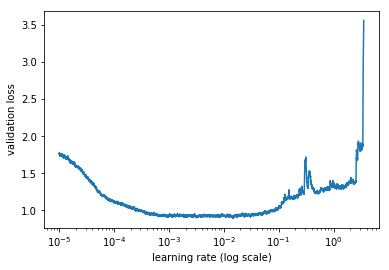

In [10]:
learn.sched.plot()

From the plot above, we can see that the loss was at a minimum when the learning rate was between $10^{-3}$ and $10^{-2}$.   
Since we will be using learning rate annealing, we will choose a learning rate of $10^{-2}$, which will then decrease towards $10^{-3}$ as training progresses.

In [7]:
# set learning rate
lr = 1e-2

In [8]:
cf = CollabFilterDataset.from_csv(path, 'data_1_long.csv', 'Cust_Id', 'Movie_Id', 'Rating')
val_idxs = get_cv_idxs(cf.n)

In [9]:
n_factors = 5
batch_size = 256

## Training the model

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

 16%|█▌        | 6658/42277 [00:37<03:19, 178.12it/s, loss=0.905]

#### Stochastic Gradient Descent with resets
Another cool thing about fastai library is the way we can use this method of resetting the learning rate at each epoch.   
If the model parameters ever find their way into a local minimum, then the resetting of the learning rate helps to kick them back out again.   

![SGD with resets](https://github.com/fastai/fastai/raw/6ccb0f4e6c7ad88279dcf678da2b605e8e32aea8/courses/dl1/images/sgdr.png)   
(from the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109))

Let's take a look at the learning rate throughout the training process:

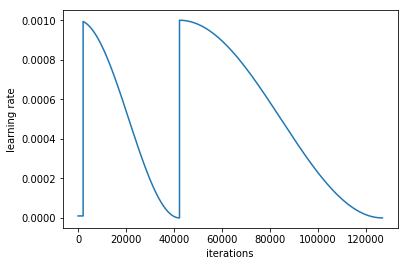

In [6]:
learn.sched.plot_lr()

## Regularization
Try and find the right value for the `wd` (weight decay) parameter below.

In [7]:
wd = 1e-6

In [8]:
learn.fit(1e-3, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.850382   0.809184  
    1      0.843988   0.809002  
    2      0.855662   0.805702  



[array([0.8057])]